# Dynamic Foraging Models: Simulation

<font size=3>Here I'm trying to outline  a simple framework that summarizes the dynamic foraging models in the literature (still under developing). I hope this can facilitate our understanding as well as our programming.

<img src="Models.png" />

<font size=3>See below (and the source code) for details.<br><font color=red>Red texts: I'm not sure.</font>

---


# Play with different foraging models (parameters yet to be optimized)

Preparation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
from foraging_testbed_simulate import *

# Try to open parallel pools (needs multiprocessing package)
try:
    n_worker = int(mp.cpu_count()/2)  # Optimal number = number of physical cores
    pool = mp.Pool(processes = n_worker)
except:
    pool = ''
    
# Parameter settings
n_trials = 1000
n_repetitions = 1000

## 1. Special foragers: Baseline Foragers (Random, IdealGreedy) and Loss Counters
### 1.1. A random forager
    

<font size=3>Note that even a random forager can achieve a foraging efficiency ~77%!<br>Foraging efficiency is defined as the actual mean reward rate divided by the averaged combined baiting probability (Corrado et al. 2005).

apply_async: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.85it/s]

--- apply_async finished in 3.99339 s---


<IPython.core.display.Javascript object>


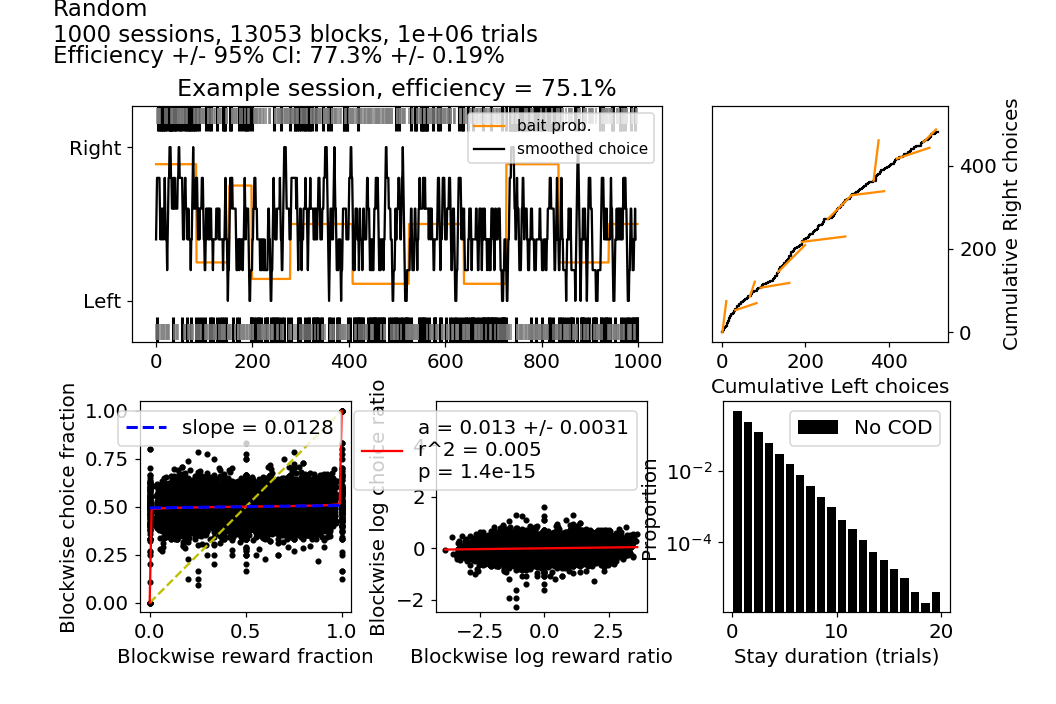

In [6]:
bandit = Bandit(forager = 'Random', n_trials = n_trials)
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 1.2 An ideal forager
    

<font size=3>    A forager who **knows** the underlying baiting probability and always chooses the **greedy** option.

apply_async: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.65it/s]

--- apply_async finished in 3.91752 s---


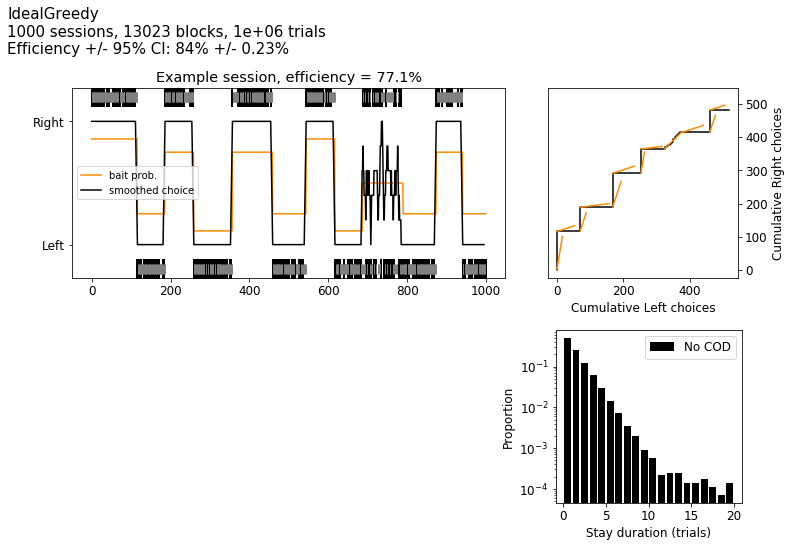

In [8]:
bandit = Bandit(forager = 'IdealGreedy')
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 1.3 Loss Counter
    

<font size=3>    A forager who switches to other option(s) if and only if the `loss_count` on one option exceeds a certain `loss_count_threshold`.

#### 1.3.1 `loss_count_threshold` = inf (Never switch, i.e., my previous AlwaysLEFT)

apply_async: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.06it/s]

--- apply_async finished in 2.96606 s---


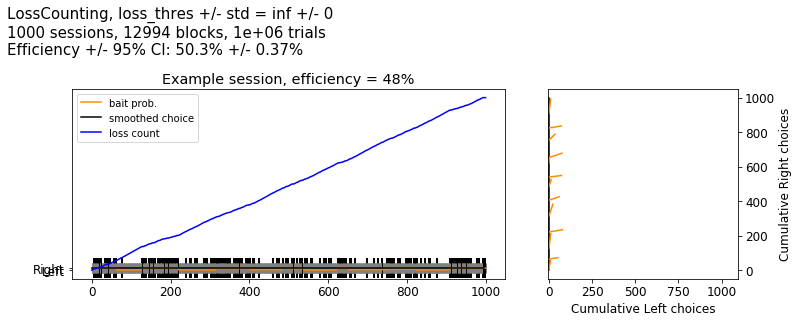

In [3]:
bandit = Bandit('LossCounting', loss_count_threshold_mean = np.inf, loss_count_threshold_std = 0)
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

#### 1.3.2 `loss_count_threshold` > 1 (Normal loss counting, Shahidi 2019)
<font size=3>    Worse than random (77%)

apply_async: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 510.27it/s]

--- apply_async finished in 1.98668 s---


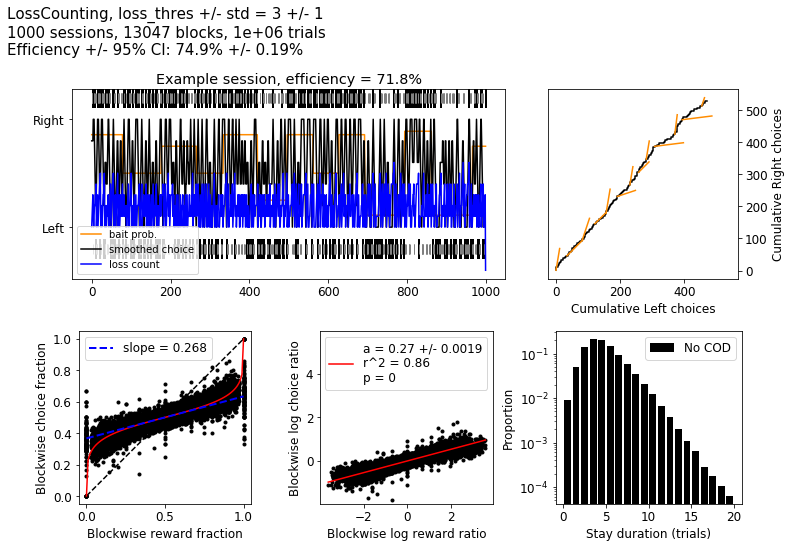

In [4]:
bandit = Bandit('LossCounting', loss_count_threshold_mean = 3, loss_count_threshold_std = 1)
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

#### 1.3.3 `loss_count_threshold` = 1 (win-stay-lose-switch)
<font size=3>    This simple strategy even outperforms the ideal forager! (note that we don't have COD)

apply_async: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.22it/s]

--- apply_async finished in 2.22505 s---


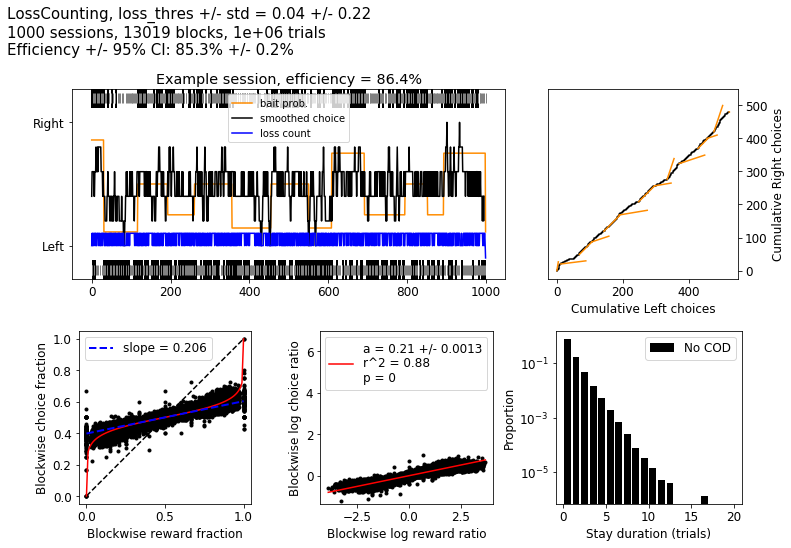

In [4]:
bandit = Bandit('LossCounting', loss_count_th reshold_mean = 0.04, loss_count_threshold_std = 0.22)
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

#### 1.3.4 `loss_count_threshold` = 0 (always switch)
<font size=3>   Again, this is why need COD...

apply_async: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.65it/s]

--- apply_async finished in 2.37664 s---


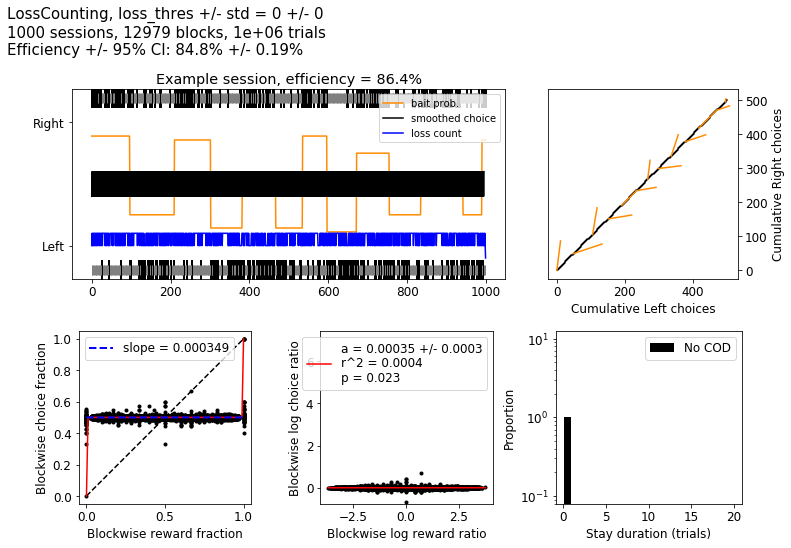

In [6]:
bandit = Bandit('LossCounting', loss_count_threshold_mean = 0, loss_count_threshold_std = 0)
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

---
## 2. LNP-like foragers: Sugrue2004, Corrado2005, and Iigaya2019

<font size=3> They share the same structure:

**Income History -> Linear Filter (single/multi- exp.) -> Mapping Function (fractional/softmax) -> Poisson choice probability**<br><br>

### 2.1 [Sugrue 2004: Income history + Single exponential + Fractional + Choice probability](https://science.sciencemag.org/content/304/5678/1782.long)

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 167.11it/s]

--- apply_async finished in 2.99603 s---


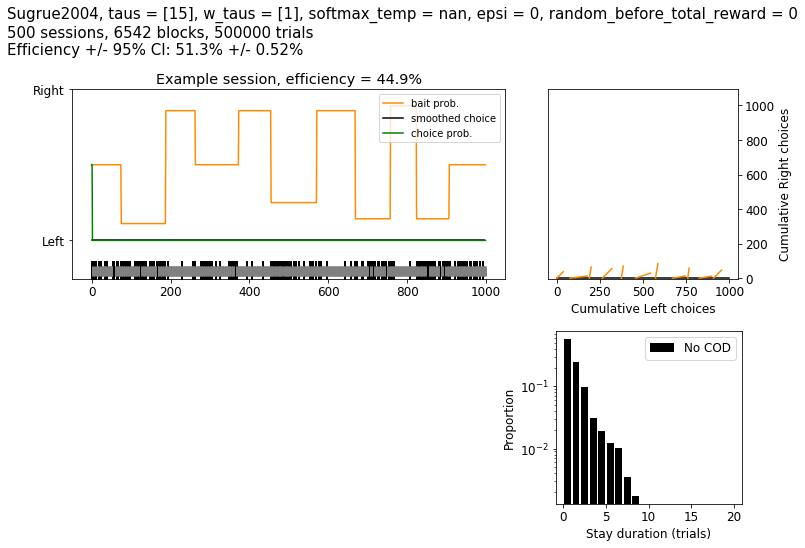

In [5]:
bandit = Bandit(forager = 'Sugrue2004', taus = 15, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

<font size=5>**It fails...**</font>

<font size=3> Seems that the green curve converges to 0 or 1 quickly, and the forager never explores. This is because Sugrue2004 uses a "fractional" operation, i.e., $p_i = I_i/\sum(I_i)$, which becomes 0 or 1 immediately after the forager receives the **first reward** in a session. The authors did not talk about this in their paper. Instead, they claimed that their "simple model has only one tuned parameter". But I think we need an explicit mechanism to encourage exploration here. <font color='red' size=4>**(Did I make any mistakes? Please help...)**</font> 

A simple way could be using the epsilon-rule (see [Sutton&Barto's RL book](http://www.incompleteideas.net/book/RLbook2018.pdf), p.28). Therfore, I introduced a free parameter `epsilon` to indicate the probability with which the forager makes random guesses  on each trial (kind of "lapse rate"). Here's the result of `epsilon` = 0.15. Looks much better.

apply_async: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.57it/s]

--- apply_async finished in 5.45341 s---


<IPython.core.display.Javascript object>


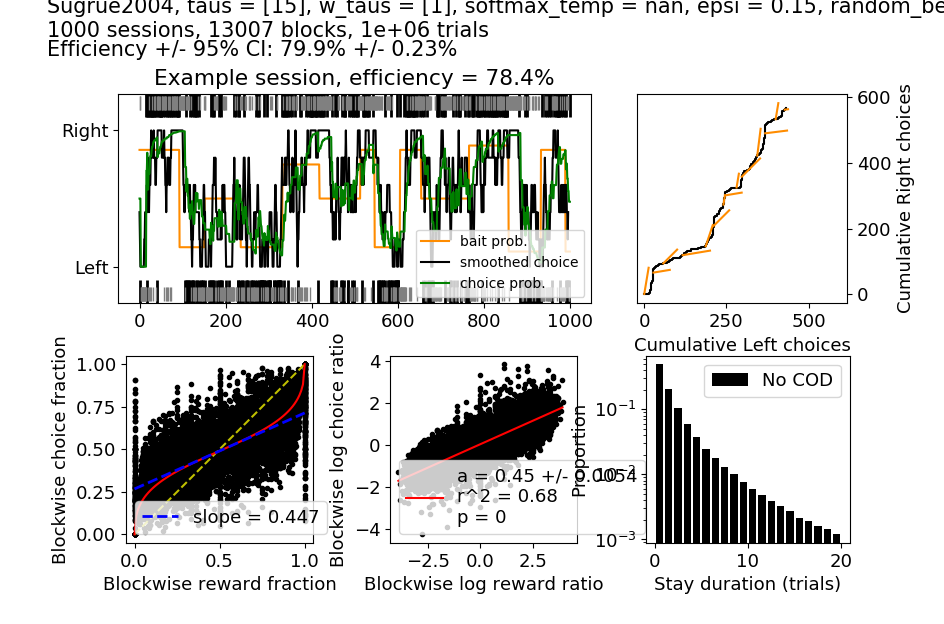

In [5]:
bandit = Bandit(forager = 'Sugrue2004', taus = 15, epsilon = 0.15, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 2.2 [Corrado2005: Income history + Double-exponential + Softmax + Choice probability](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1389782)
<font size=3> In contrast to Sugrue 2004, Corrado 2005 uses a double-exponential filter and `softmax` rather than `fractional` in the step of mapping value estimation to choice probability.

Note that `softmax` here is equivalent to *difference + sigmoid non-linearity* described in their paper.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 160.40it/s]

--- apply_async finished in 3.12219 s---


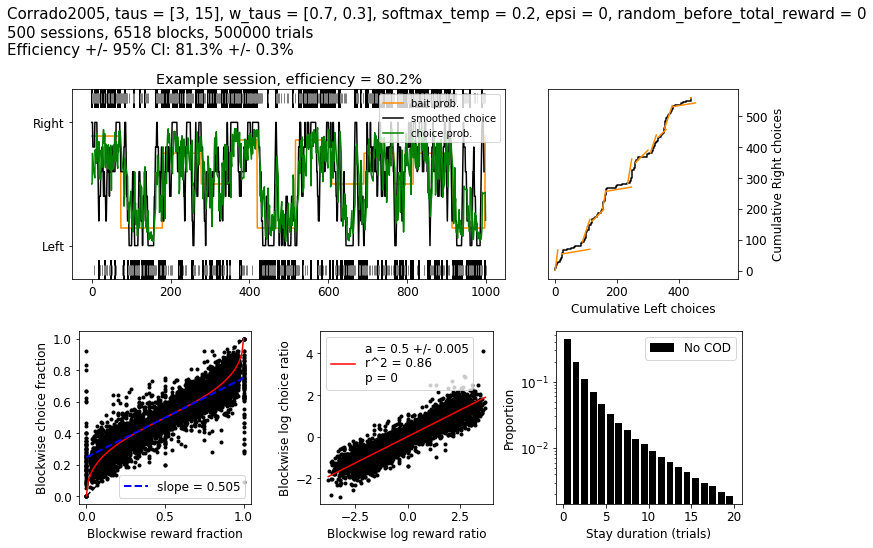

In [7]:
bandit = Bandit(forager = 'Corrado2005', taus = [3, 15], w_taus = [0.7, 0.3], softmax_temperature = 0.2, epsilon = 0, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

<font size=3> Corrado2005 does **NOT** require `epsilon` > 0, because its `softmax` mapping function prevents $p_i$ from reaching exactly 0 or 1, thus encouraging exploration. 

### 2.3 [Iigaya2019: Income history + Double-/Triple- exponential + Fractional + Choice probability](https://www.nature.com/articles/s41467-019-09388-3)
<font size=3> In Iigaya et al. 2019, they used *fractional mapping* again, like Sugrue2004. So it will not work without an explicit exploration mechanism.

<font color='red' size=4>**(again, am I right?)**</font>

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 166.50it/s]

--- apply_async finished in 3.00802 s---


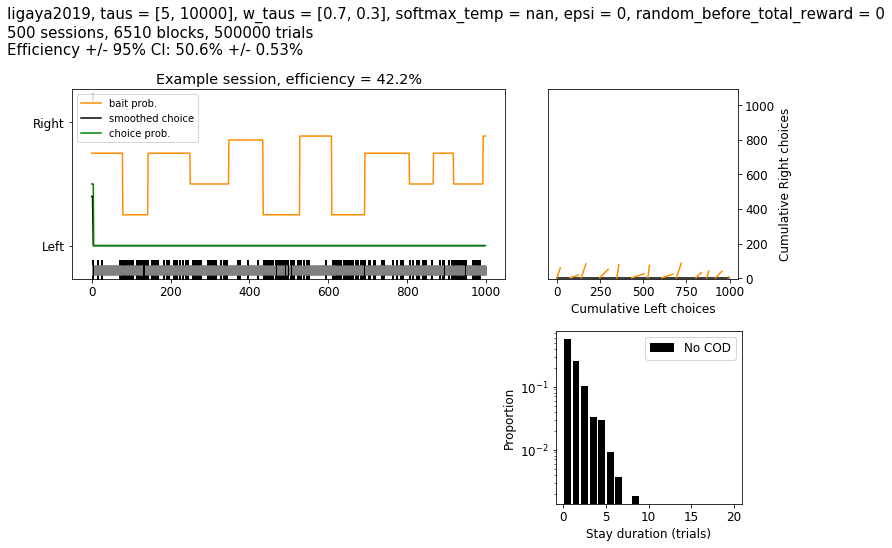

In [8]:
bandit = Bandit(forager = 'Iigaya2019', taus = [5,10000], w_taus = [0.7, 0.3], n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool); 

 <font size=3> To rescue this, we may add a small `epsilon`, just like in Sugrue 2004.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 161.07it/s]

--- apply_async finished in 3.10929 s---


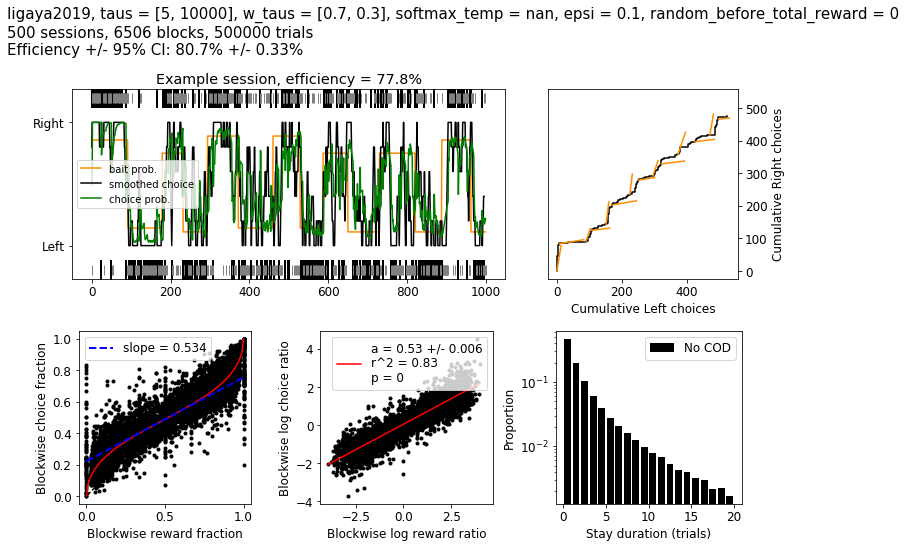

In [9]:
bandit = Bandit(forager = 'Iigaya2019', taus = [5,10000], w_taus = [0.7, 0.3], epsilon = 0.1, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);  

<font size=3> Or, alternatively, we may add an **initial exploration period** to encourage exploration at the begining of a session, as suggested in [Marton's code](https://github.com/rozmar/DataPipeline/blob/3811ab7c8e2062d7410bf3a8fb92e75313613a9b/Behavior/foraging_model/foraging_model.py#L38). The forager makes random choices before the total number of rewards exceeds `random_before_total_reward`.

Magically, with this short **initial exploration period** (20, for example), the forager can do a decent job in the rest of a long session (2000 trials, for example):

apply_async: 100%|███████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.52it/s]

--- apply_async finished in 6.45427 s---


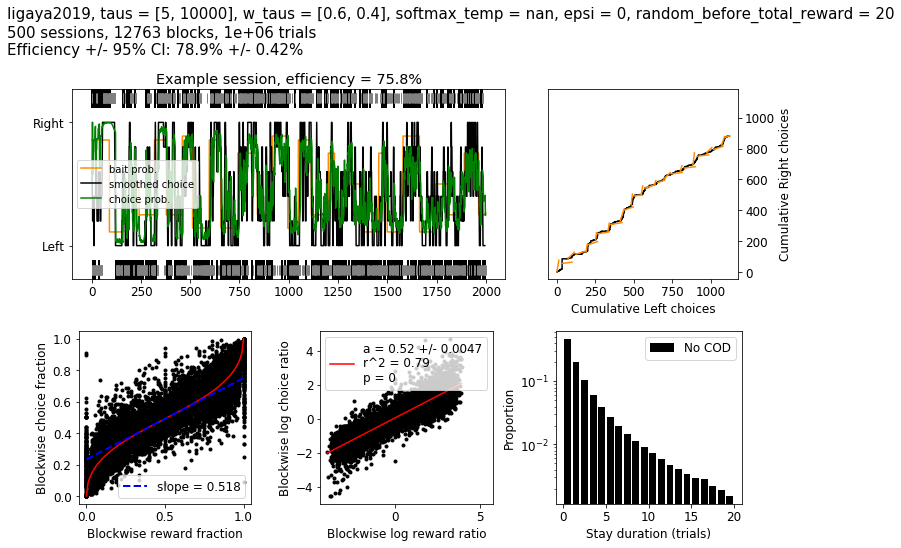

In [10]:
bandit = Bandit(forager = 'Iigaya2019', taus = [5,10000], w_taus = [0.6, 0.4], random_before_total_reward = 20, n_trials = 2000) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);  

<font size=3>My intuition of why this works is that the extremely long time constant (e.g., 10000) tends to have balanced contributions to the two choices in a long run, thus adding a small baseline probability to each of them (corresponding to `epsilon/2` in the $\epsilon$-method). But it needs some time to build up this balance, and this is why we need the initial forced exploration period to kick it off.

Consistent with this notion, `random_before_total_reward` has **no persistent effect without the help of a long time constant**, as shown in the case of Sugrue 2004:

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 165.29it/s]

--- apply_async finished in 3.02895 s---


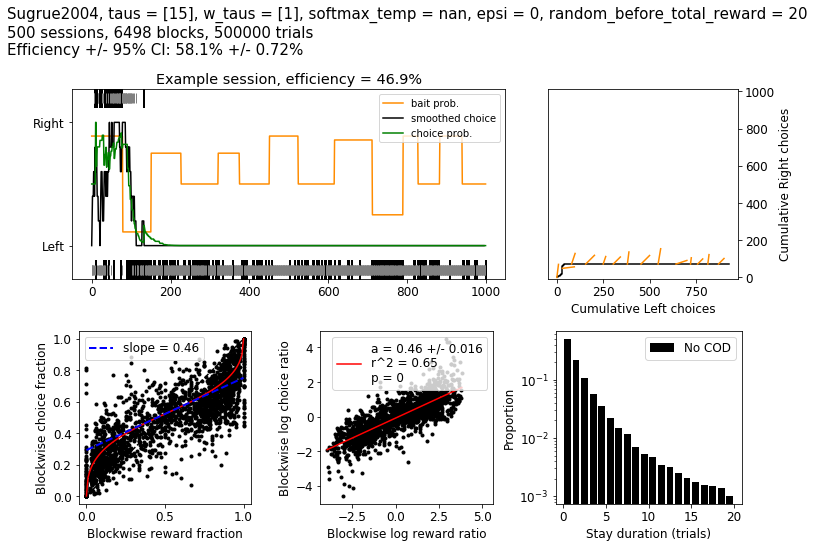

In [20]:
bandit = Bandit(forager = 'Sugrue2004', taus = 15, epsilon = 0, random_before_total_reward = 20, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

<font size=3> Taken together, exploration is essential for dynamic foraging. The key idea of exploration is to prevent $p_i$ from getting trapped at 0 or 1.<br> We have several options:<br>
1. Use `epsilon` to add a (hard) baseline probability, such that $\bar{p_i}>\epsilon/2$ (Sugrue2004)
2. Use `softmax` to add a (soft) baseline probability (Corrado2005)
3. Use a long time constant together with an initial exploration period (Iigaya2019) <br>

(If I'm the subject, I would choose option 1, because it's much simpler to just be lazy than to remember a long reward history!!)<br>
    
Again, I don't know why neither Sugrue et al. 2004 nor Iigaya et al. 2019 has discussed about this... <font color='red' size=3> Did I miss something?


## 3. RL-like foragers: SuttonBartoRLBook, Bari2019, and Hattori2019
<font size=3>All of them are reinforcement-learning-style foragers in the sense that they estimate **action values** $Q_i$. I summarized their algorithms into a general form <font color=red>(please check this)</font>:<br>    
    &emsp;&emsp;$Q_{ch}(t+1) = (1-\delta_{ch})*Q_{ch}(t) + \alpha_{reward}*(reward - Q_{ch}(t))$<br>
    &emsp;&emsp;$Q_{unch}(t+1) = (1-\delta_{unch})*Q_{unch}(t) $
    
where $Q_{ch}$ and $Q_{unch}$ are *action values* of the chosen and unchosen options, respectively; $\delta$s are their corresponding *forgetting rates*, and $\alpha_{reward}$ is a reward-dependent *learning rate*; $reward\in\{0,1\}$.<br><br>
Specifically:<br>
<font size=3>&emsp;For ['SuttonBartoRLBook'](http://www.incompleteideas.net/book/RLbook2018.pdf),&emsp; $\delta_{ch} = \delta_{unch} = 0, \alpha_0 = \alpha_1$,&emsp;&emsp;&emsp;&emsp;&emsp;followed by `epsilon-greedy`<br>
    &emsp;For ['Bari2019'](https://www.ncbi.nlm.nih.gov/pubmed/31280924),&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\delta_{ch} = \delta_{unch} = 1-\zeta > 0, \alpha_0 = \alpha_1$&emsp;&emsp;&emsp;followed by `softmax-Poisson`<br>
    &emsp;For ['Hattori2019'](https://www.ncbi.nlm.nih.gov/pubmed/31080067), &emsp;&emsp;&emsp;&emsp;&emsp;$\delta_{ch}=0, \delta_{unch}=\delta, \alpha_0 \ne \alpha_1$&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;followed by `softmax-Poisson`<br>
    
Note that updating $Q$ as above is quite similar to applying an exponential filter in LNP-like foragers, with an `effective time constant` of<br>$$\tau_{eff}=-\frac{1}{ln(1-(\alpha+\delta))}\approx\frac{1}{\alpha+\delta}$$
However, RL-like foragers compute local **return** rather than local **income** because they only actively update $Q_{ch}$ (at least when $\delta_{unch}=0$). See discussion in Corrado et al. 2005.

### 3.1 'SuttonBartoRLBook'
<font size=3>Modified from the solution to the `bandit` problem in Chapter 2 of their [RL book](http://www.incompleteideas.net/book/RLbook2018.pdf) (see Rescorla and Wagner 1972).

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 134.51it/s]

--- apply_async finished in 3.72212 s---


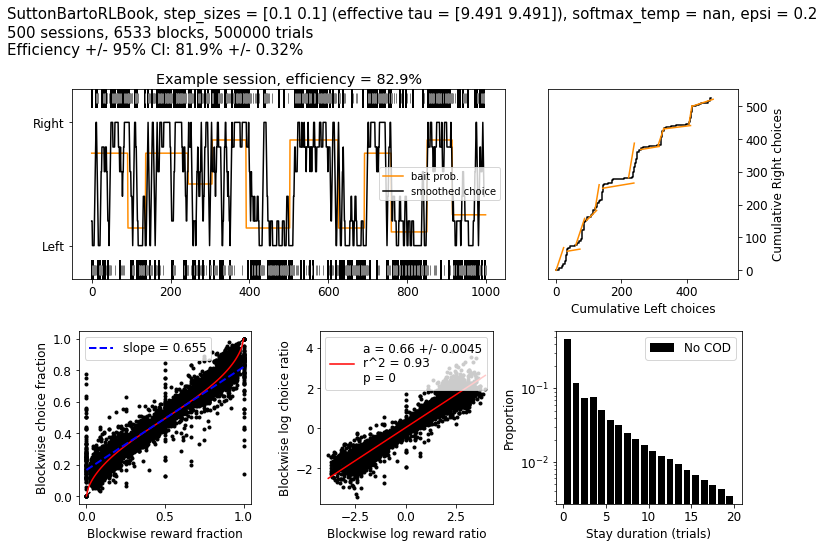

In [12]:
bandit = Bandit(forager = 'SuttonBartoRLBook',step_sizes = 0.1, epsilon = 0.2, n_trials = n_trials)
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 3.2 'Bari2019'

<font size=3>The outcome is very sensitive to `softmax_temperature`.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 155.26it/s]

--- apply_async finished in 3.22445 s---


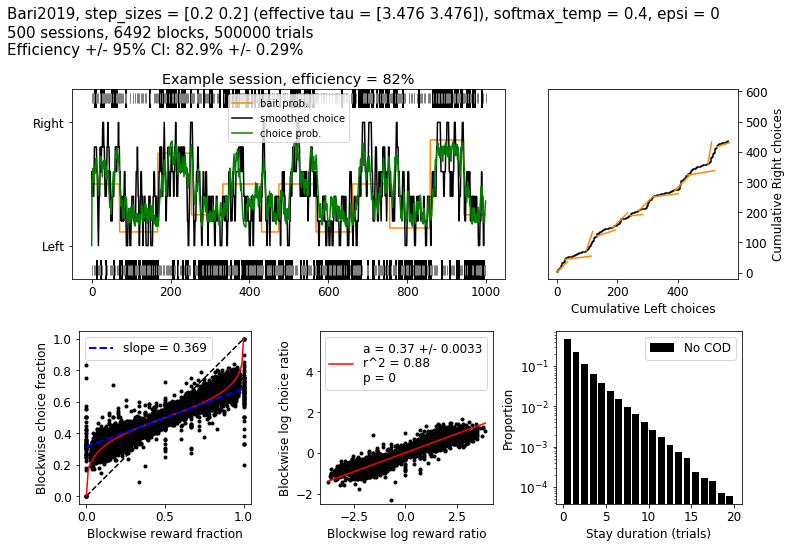

In [13]:
bandit = Bandit(forager = 'Bari2019', step_sizes = 0.2, forget_rate = 0.05, softmax_temperature = 0.4,  epsilon = 0, n_trials = n_trials)  
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 3.3 'Hattori2019'

<font size=3>The most volatile (and thus also the most efficient) one in the RL-like foragers.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 155.98it/s]

--- apply_async finished in 3.20947 s---


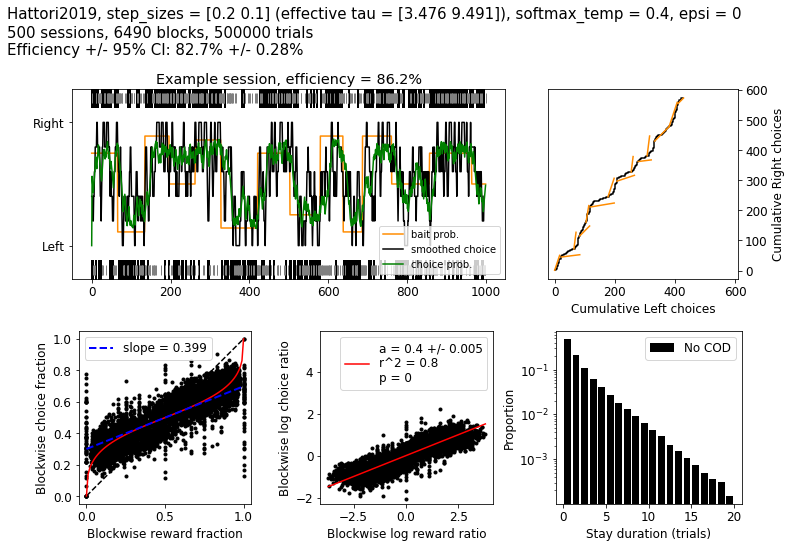

In [14]:
bandit = Bandit(forager = 'Hattori2019', epsilon = 0,  step_sizes = [0.2, 0.1], forget_rate = 0.05, softmax_temperature = 0.4, n_trials = n_trials)   
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

---

# Parameter Scan to Reproduce Previous Results

## Figure 2C in Sugrue et al., 2004

<font size=3>Let's first try `epsilon = 0.15`

apply_async: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [00:18<00:00, 163.85it/s]

--- apply_async finished in 18.3595 s---


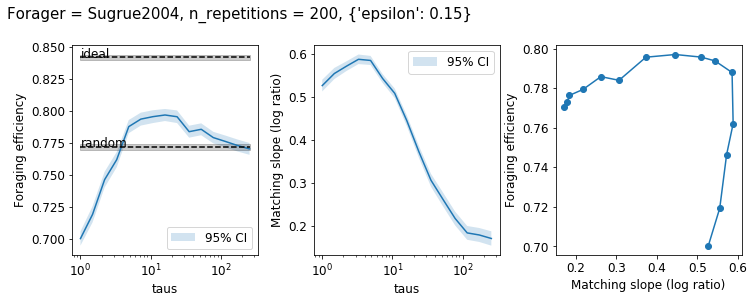

In [15]:
para_to_scan = {'taus': np.power(2, np.linspace(0,8,15))}
para_scan('Sugrue2004', para_to_scan, epsilon = 0.15, n_reps = 200, pool = pool);

<font size=3> The foraging efficiency drops dramatically when $\tau$ is small, which is not the case in their paper. As discussed previously, this result should depend on `epsilon`. So let's try `epsilon = 0.5` instead.

apply_async: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [00:18<00:00, 159.19it/s]

--- apply_async finished in 18.9111 s---


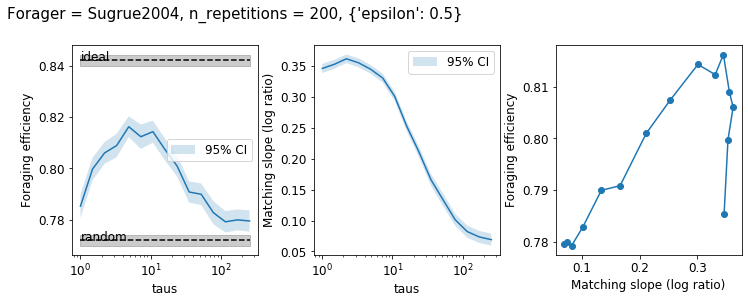

In [16]:
para_to_scan = {'taus': np.power(2, np.linspace(0,8,15))}
para_scan('Sugrue2004', para_to_scan, epsilon = 0.5, n_reps = 200, pool = pool);

<font size=3> Now the left panel looks more similar to Sugrue's Figure 2C.

<font size=3> We can also try a 2-D para scan.

apply_async: 100%|████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 165.96it/s]

--- apply_async finished in 30.1793 s---


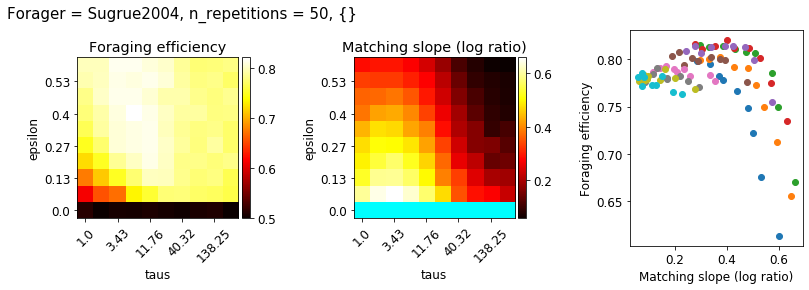

In [17]:
para_to_scan = {'taus': np.power(2, np.linspace(0,8,10)),
                'epsilon': np.linspace(0,0.6,10),
                }
para_scan('Sugrue2004', para_to_scan, n_reps = 50, pool = pool);

<font size=3>Note that better matching does not necessarily lead to larger foraging efficiency, as suggested by Iigaya et al 2019. However, the matching slope is only ~0.3 for the best $\tau$, which seems impossible to fit Sugrue's monkey data...<br>
    
    
<font size=5 color=red>Again, did I miss something?

## Figure 11B of Corrado et al 2005

apply_async: 100%|████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 164.81it/s]

--- apply_async finished in 30.3904 s---


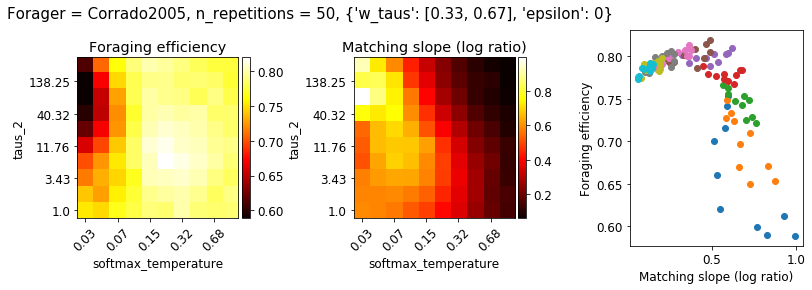

In [18]:
taus = [[2, tau_2] for tau_2 in np.power(2, np.linspace(0,8,10))]
para_to_scan = {'softmax_temperature': np.power(10, np.linspace(-1.5,0,10)),
                'taus': taus,
                }
para_scan('Corrado2005', para_to_scan, w_taus = [0.33, 0.67],  epsilon = 0, n_reps = 50, pool = pool);

<font size=3>Looks great! Thanks to `softmax`, there is no `epsilon` issue in this paper)

## Figure 3d and 3e of Iigaya et al, 2019

apply_async: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 165.87it/s]

--- apply_async finished in 12.0679 s---


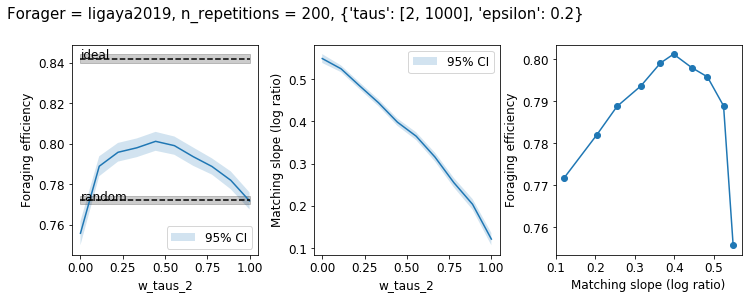

In [19]:
w_taus = [[1-w_slow, w_slow] for w_slow in np.linspace(0,1,10)]
para_to_scan = {'w_taus': w_taus}
para_scan('Iigaya2019', para_to_scan, taus = [2,1000],  epsilon = 0.2, n_reps = 200, pool = pool);

<font size=3>Looks similar to their figures. However, again, my plots here depend on `epsilon`.

# Parameter Optimization to Compare Model Performance

## ~1. (obsolete) Use manual pre-scans (2-d) to find the best 1-d scan direction~

**Loss Counter:** loss_count_threshold_mean {loss_count_threshold_std = 0}

apply_async: 100%|████████████████████████████████████████████████████████████████| 7200/7200 [00:13<00:00, 537.95it/s]

--- apply_async finished in 13.458 s---


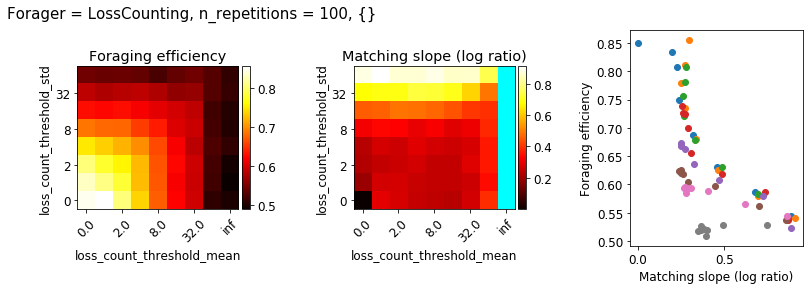

In [17]:
para_to_scan = {'loss_count_threshold_mean': np.hstack([0,np.power(2,np.r_[0:7]),np.inf]),
                'loss_count_threshold_std': np.hstack([0,np.power(2,np.r_[0:7])]),
                }
para_scan('LossCounting', para_to_scan, n_reps = 100, pool = pool);

**Sugrue 2004**: taus {epsilon = 0.3}

apply_async: 100%|████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 174.81it/s]

--- apply_async finished in 28.6269 s---


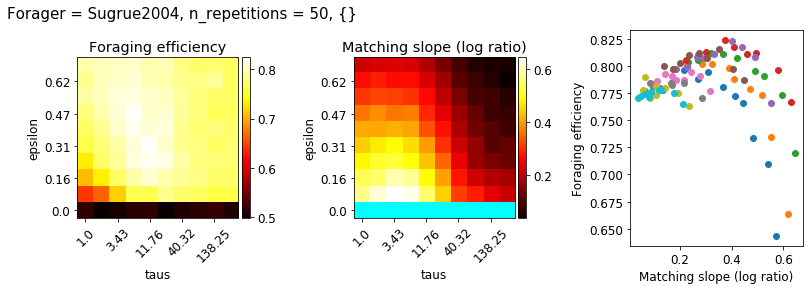

In [26]:
para_to_scan = {'taus': np.power(2, np.linspace(0,8,10)),
                'epsilon': np.linspace(0,0.7,10),
                }
para_scan('Sugrue2004', para_to_scan, n_reps = 50, pool = pool);

**Corrado2005**: taus {epsilon = 0.3}

apply_async: 100%|████████████████████████████████████████████████████████████████| 5000/5000 [00:27<00:00, 179.82it/s]

--- apply_async finished in 27.829 s---


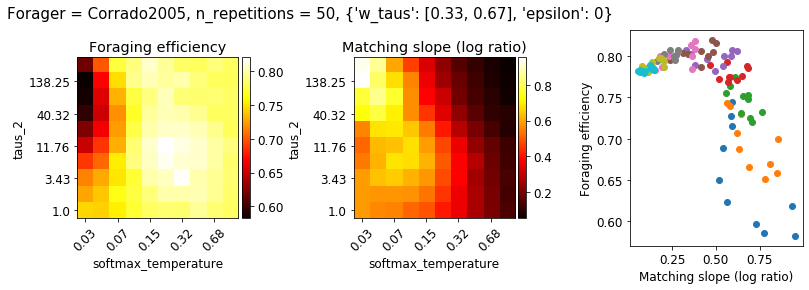

In [27]:
taus = [[2, tau_2] for tau_2 in np.power(2, np.linspace(0,8,10))]
para_to_scan = {'softmax_temperature': np.power(10, np.linspace(-1.5,0,10)),
                'taus': taus,
                }
para_scan('Corrado2005', para_to_scan, w_taus = [0.33, 0.67],  epsilon = 0, n_reps = 50, pool = pool);

**Hattori2019**: I'm curious about whether two different step_sizes for rew/unrew are meaningful (at least to peformance)

apply_async: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [00:16<00:00, 182.29it/s]

--- apply_async finished in 16.4719 s---


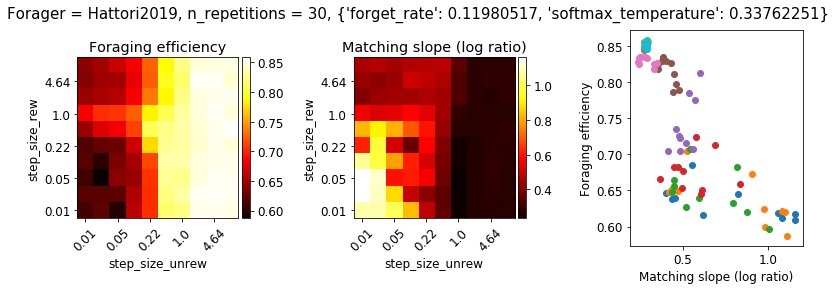

In [4]:
para_to_scan = {'step_size_unrew': np.power(10, np.linspace(-2,1,10)),
                'step_size_rew': np.power(10, np.linspace(-2,1,10)),
                }
para_scan('Hattori2019', para_to_scan, forget_rate = 0.11980517, softmax_temperature = 0.33762251, n_reps = 30, pool = pool);

The asymmetric dependence on `step_size_rew` and `step_size_unrew` is interesting.  <br>
When `step_size_unrew` is large, the performance is perfect. Does it act like loss-switch??

apply_async: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 179.95it/s]

--- apply_async finished in 5.56312 s---


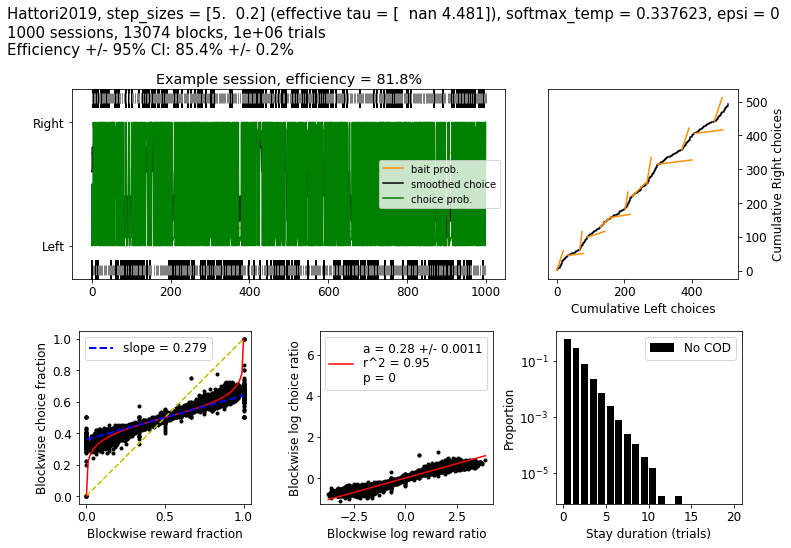

In [5]:
bandit = Bandit(forager = 'Hattori2019', step_sizes = [5, 0.2], forget_rate = 0.11980517, softmax_temperature = 0.33762251, n_trials = n_trials)   
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

<font size =5> Exactly!

## 2. Use automatic parameter optimization (differential evolution algorithm)

Searching parameters manually is so tedious. I adopt to use `scipy.optimize` package for automatic parameter optimization.<br>
The cost function is simple:$$CostFunction = - ForagingEfficiency$$<br>My preliminary tests suggest that `scipy.optimize.differential_evolution` is promising. See [document](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) and a detailed [tutorial](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/).<br><br>
<font size =4> Caution: this section is very time-consuming! So, go to the Bob's for a cup of coffee...

### 2.1 Loss Counting

differential_evolution step 1: f(x)= -0.712933
differential_evolution step 2: f(x)= -0.716711
differential_evolution step 3: f(x)= -0.850311
differential_evolution step 4: f(x)= -0.851356
differential_evolution step 5: f(x)= -0.851356
differential_evolution step 6: f(x)= -0.851356
differential_evolution step 7: f(x)= -0.857733
differential_evolution step 8: f(x)= -0.857733
differential_evolution step 9: f(x)= -0.858489
differential_evolution step 10: f(x)= -0.858489
differential_evolution step 11: f(x)= -0.858489
differential_evolution step 12: f(x)= -0.858489
differential_evolution step 13: f(x)= -0.858489
differential_evolution step 14: f(x)= -0.859756
differential_evolution step 15: f(x)= -0.859756


apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 481.13it/s]

--- apply_async finished in 1.04321 s---


     fun: -0.8597555555555552
 message: 'Optimization terminated successfully.'
    nfev: 733
     nit: 15
 success: True
       x: array([0.37879938, 0.18915971])
--- para_optimize finished in 148.91 s ---


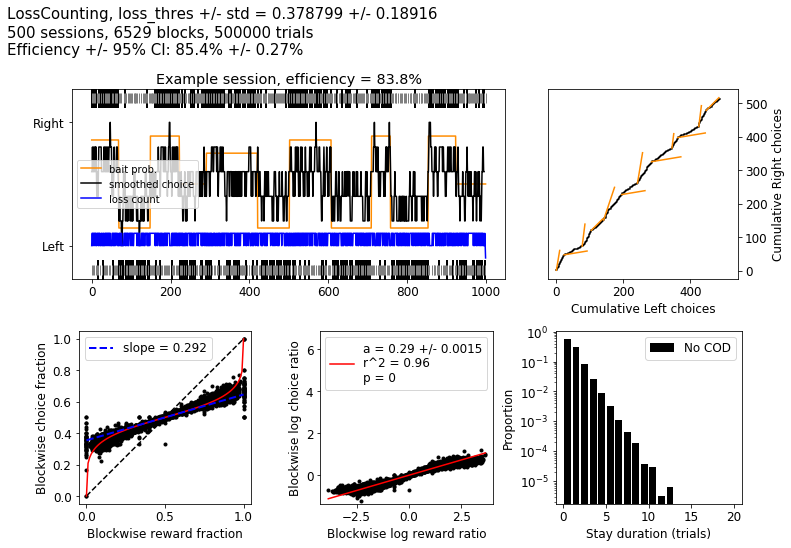

In [3]:
para_optimize('LossCounting', n_reps_per_iter = 100, pool = pool)

### 2.2 Sugrue2004

differential_evolution step 1: f(x)= -0.814993
differential_evolution step 2: f(x)= -0.822104
differential_evolution step 3: f(x)= -0.822104
differential_evolution step 4: f(x)= -0.822104
differential_evolution step 5: f(x)= -0.822104
differential_evolution step 6: f(x)= -0.822104
differential_evolution step 7: f(x)= -0.823985


apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 178.99it/s]

--- apply_async finished in 2.79752 s---


     fun: -0.823985185185185
 message: 'Optimization terminated successfully.'
    nfev: 410
     nit: 7
 success: True
       x: array([5.34966058, 0.40805461])
--- para_optimize finished in 367.608 s ---


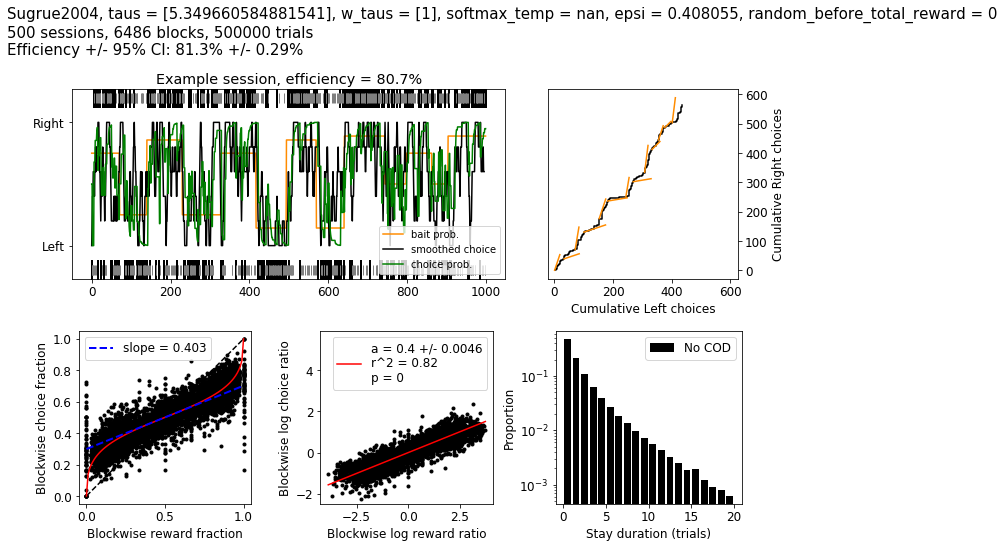

In [4]:
para_optimize('Sugrue2004', n_reps_per_iter = 150, pool = pool)

### 2.3 Corrado 2005

When all parameters are free to change, best w_tau_long is only 0.05.

differential_evolution step 1: f(x)= -0.827789
differential_evolution step 2: f(x)= -0.827789
differential_evolution step 3: f(x)= -0.828222
differential_evolution step 4: f(x)= -0.828222


apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 186.65it/s]

--- apply_async finished in 2.68482 s---


     fun: -0.828222222222222
 message: 'Optimization terminated successfully.'
    nfev: 515
     nit: 4
 success: True
       x: array([ 6.17853872, 30.31342409,  0.04822465,  0.18704151])
--- para_optimize finished in 550.155 s ---


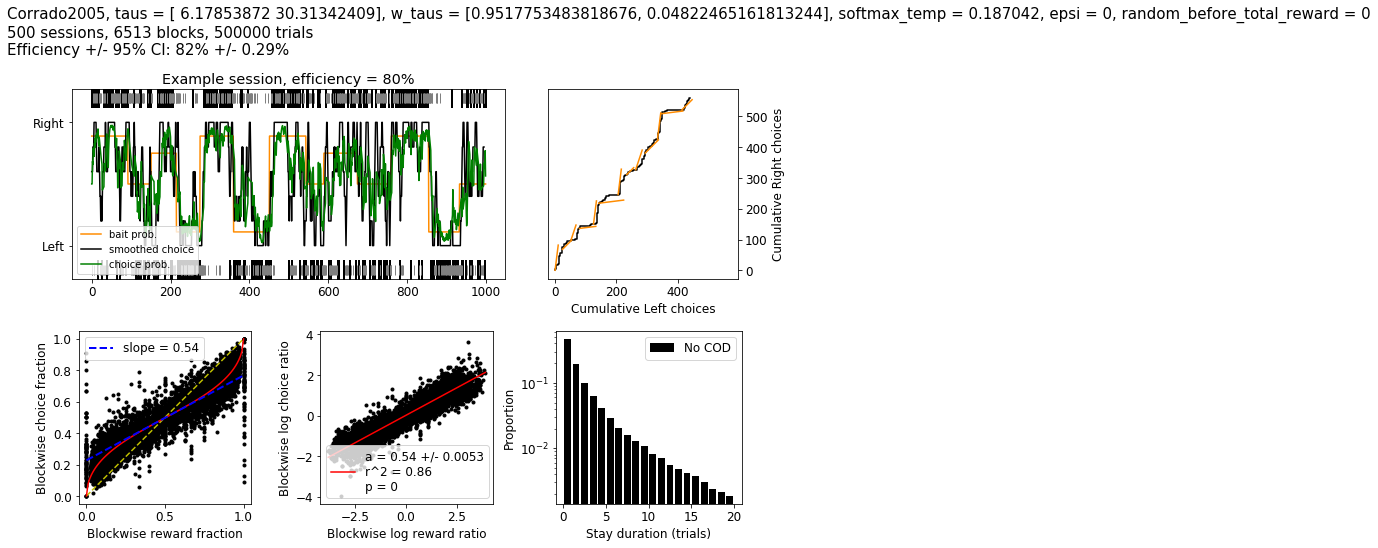

In [3]:
opti_para = para_optimize('Corrado2005', n_reps_per_iter = 200, pool = pool)

What if we fix w_taus = [0.33, 0.67] (as in their paper)?

differential_evolution step 1: f(x)= -0.818304
differential_evolution step 2: f(x)= -0.820467
differential_evolution step 3: f(x)= -0.820467
differential_evolution step 4: f(x)= -0.8222


apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 174.20it/s]

--- apply_async finished in 2.87631 s---


     fun: -0.8242888888888886
     jac: array([486666.66666667,  42962.96296294, 116296.29629628])
 message: 'Optimization terminated successfully.'
    nfev: 372
     nit: 4
 success: True
       x: array([ 3.39769223, 10.01672554,  0.19932293])
['tau1', 'tau2', 'softmax_temperature']
--- para_optimize finished in 611.208 s ---


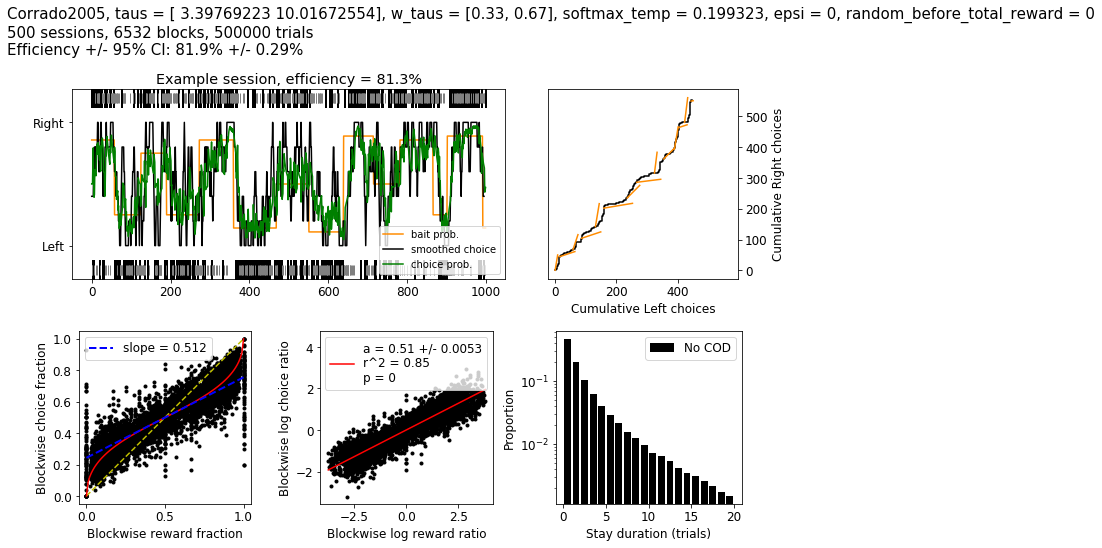

In [9]:
opti_para = para_optimize('Corrado2005_fixW', n_reps_per_iter = 300, pool = pool)

Similar to 2-D manual scan we did previously.

Let's try RL-like foragers.

### 2.4 Bari 2019

differential_evolution step 1: f(x)= -0.844544
differential_evolution step 2: f(x)= -0.844544
differential_evolution step 3: f(x)= -0.845767
differential_evolution step 4: f(x)= -0.845767
differential_evolution step 5: f(x)= -0.845767
differential_evolution step 6: f(x)= -0.848611


apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 175.42it/s]

--- apply_async finished in 2.85337 s---


     fun: -0.8486111111111109
 message: 'Optimization terminated successfully.'
    nfev: 516
     nit: 6
 success: True
       x: array([0.37058271, 0.07003851, 0.27212561])
--- para_optimize finished in 599.81 s ---


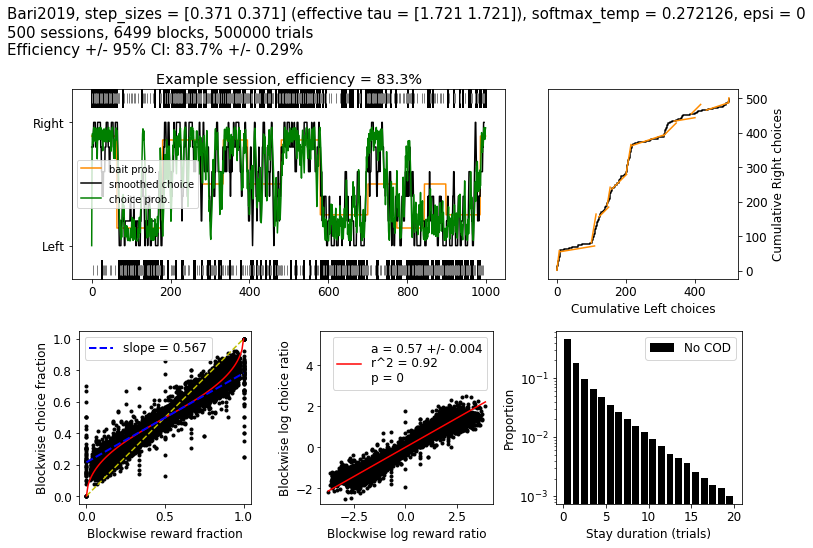

In [5]:
para_optimize('Bari2019', n_reps_per_iter = 200, pool = pool)

### 2.5 Hattori 2019 (the most versatile one)

differential_evolution step 1: f(x)= -0.844756
differential_evolution step 2: f(x)= -0.844941
differential_evolution step 3: f(x)= -0.845252
differential_evolution step 4: f(x)= -0.84597
differential_evolution step 5: f(x)= -0.84597
differential_evolution step 6: f(x)= -0.846185


apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 172.82it/s]

--- apply_async finished in 2.89925 s---


     fun: -0.846185185185185
 message: 'Optimization terminated successfully.'
    nfev: 665
     nit: 6
 success: True
       x: array([0.39740558, 0.22740528, 0.11980517, 0.33762251])
['step_size_unrew', 'step_size_rew', 'forget_rate', 'softmax_temperature']
--- para_optimize finished in 1158.37 s ---


     fun: -0.846185185185185
 message: 'Optimization terminated successfully.'
    nfev: 665
     nit: 6
 success: True
       x: array([0.39740558, 0.22740528, 0.11980517, 0.33762251])

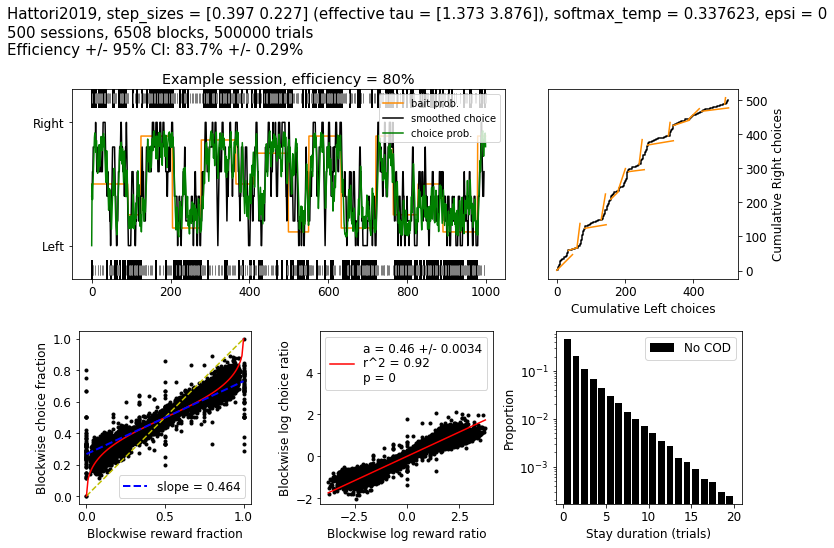

In [11]:
para_optimize('Hattori2019', n_reps_per_iter = 300, pool = pool);

differential_evolution step 1: f(x)= -0.856156
differential_evolution step 2: f(x)= -0.8586
differential_evolution step 3: f(x)= -0.8586
differential_evolution step 4: f(x)= -0.8586
differential_evolution step 5: f(x)= -0.8586


apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 171.93it/s]

--- apply_async finished in 2.91221 s---


     fun: -0.8585999999999998
 message: 'Optimization terminated successfully.'
    nfev: 585
     nit: 5
 success: True
       x: array([2.51541892, 2.77810415, 0.24318746, 0.15963342])
['step_size_unrew', 'step_size_rew', 'forget_rate', 'softmax_temperature']
--- para_optimize finished in 1006.75 s ---


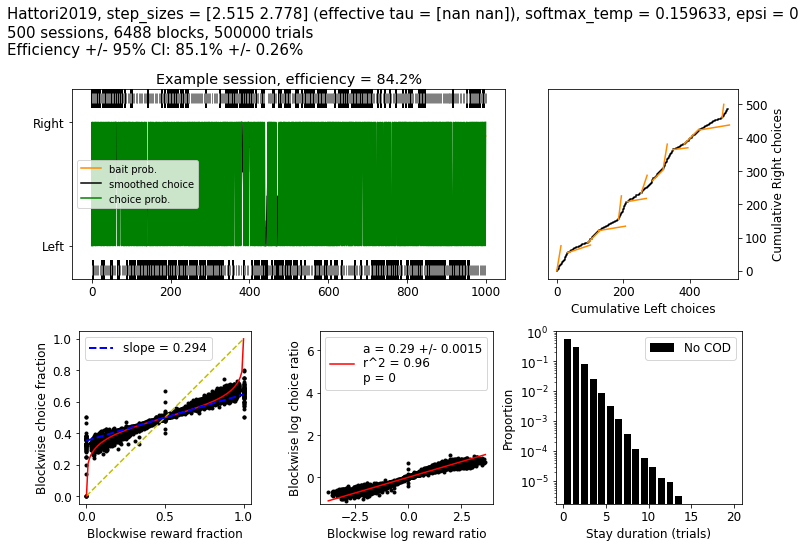

In [6]:
# Override using a larger range
para_optimize('Hattori2019',  opti_names = ['step_size_unrew', 'step_size_rew', 'forget_rate', 'softmax_temperature'],
              bounds = optimize.Bounds([0.01,0.01, 0, 0.1],[3, 3, 0.5, 1]), 
              n_reps_per_iter = 300, pool = pool);

Of course this is not what we mean to get... So we should definitely use a smaller range.

## 3. Model Competition (1-d slice across the global optimum of each model)

apply_async: 100%|████████████████████████████████████████████████████████████████| 4500/4500 [00:08<00:00, 525.27it/s]

--- apply_async finished in 8.58903 s---



apply_async: 100%|████████████████████████████████████████████████████████████████| 4800/4800 [00:26<00:00, 178.18it/s]

--- apply_async finished in 26.9599 s---



apply_async: 100%|████████████████████████████████████████████████████████████████| 4800/4800 [00:25<00:00, 187.83it/s]

--- apply_async finished in 25.5756 s---



apply_async: 100%|████████████████████████████████████████████████████████████████| 4800/4800 [00:27<00:00, 176.67it/s]

--- apply_async finished in 27.2132 s---



apply_async: 100%|████████████████████████████████████████████████████████████████| 4800/4800 [00:27<00:00, 174.85it/s]

--- apply_async finished in 27.4965 s---


<IPython.core.display.Javascript object>


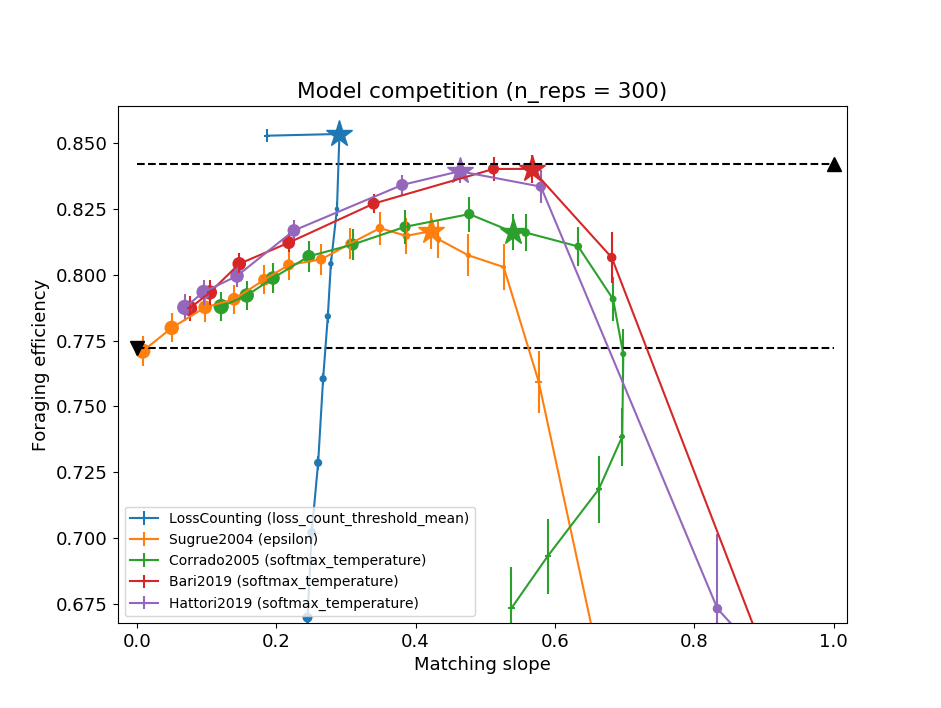

In [6]:
model_compet_settings = [
    {'forager': 'LossCounting', 
     'para_to_scan': {'loss_count_threshold_mean': np.hstack([0.37879938, 0,np.power(2,np.linspace(0,6,13))])}, 
     'para_to_fix': {'loss_count_threshold_std': 0.18915971}}, 
    {'forager': 'Sugrue2004', 
     'para_to_scan': {'epsilon': np.hstack([0.313648, np.linspace(0.001,1,15)])},
     'para_to_fix':  {'taus': 9.88406144}},
    {'forager': 'Corrado2005', 
      'para_to_scan': {'softmax_temperature': np.hstack([0.18704151, np.power(10, np.linspace(-1.5,0,15))])}, 
      'para_to_fix':  {'taus':  [6.17853872, 30.31342409], 'w_taus': [1-0.04822465, 0.04822465]}},
    {'forager': 'Bari2019', 
      'para_to_scan': {'softmax_temperature': np.hstack([0.27212561, np.power(10, np.linspace(-1.5,0,15))])}, 
      'para_to_fix':  {'forget_rate': 0.07003851, 'step_sizes': 0.37058271}},
    {'forager': 'Hattori2019', 
     'para_to_scan': {'softmax_temperature': np.hstack([0.33762251, np.power(10, np.linspace(-1.5,0,15))])}, 
     'para_to_fix':  {'forget_rate':  0.11980517, 'step_sizes': [0.39740558, 0.22740528]}},
    ]

model_compet(model_compet_settings, n_reps = 300, pool = pool) 

Hmm... Interesting!

# Model fitting and model comparison using real data

ref: [Ten simple rules for the computational modeling of behavioral data](https://elifesciences.org/articles/49547)

---
# To-do list

1. Add more models
    - Lau 2005 (Reward history + choice history + softmax)
    - Saki 2008 (actor-critic)
    - Standard Q-learning from Sutton and Barto RL book (full state representation)
2. Add COD or switch cost (switch cost = COD?)
    - The model knows COD/switch cost
    - The model has to figure out COD/switch cost by itself
    - Marginal value theorem
3. Parameter optimization
    - ~To optimize model's performance~ (DONE)
    - To fit animals' behavior 
5. Baited vs unbaited?
6. Multiple choices or even continuous choice?
7. Model-based?